In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#!pip install -q tensorflow_datasets

In [14]:
#!pip install -q tensorflow-addons==0.20.0 typeguard==2.13.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.2 MB/s eta 0:00:00ta 0:00:01


In [19]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [3]:
!nvidia-smi

Sun Apr 27 21:17:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [22]:
import tensorflow as tf


import matplotlib.pyplot as plt
import numpy as np
import time
import os
import glob # For finding files
from IPython.display import clear_output

In [23]:
# @title Configuration Parameters

# Data parameters
BUFFER_SIZE = 1000 # Shuffle buffer size
BATCH_SIZE = 1      # Batch size (CycleGAN often uses 1)
IMG_WIDTH = 256    # Image width
IMG_HEIGHT = 256   # Image height
OUTPUT_CHANNELS = 3 # Number of output channels (RGB)
DATASET_NAME = 'cycle_gan/horse2zebra' # TFDS dataset name

# Training parameters
EPOCHS = 10 # Start with a small number for demonstration (e.g., 10). Increase for better results (e.g., 100-200)
LAMBDA_CYCLE = 10.0  # Cycle consistency loss weight
LAMBDA_ID = 5.0     # Identity loss weight (lambda_cycle * 0.5 as suggested in paper)

# Checkpoint parameters
CHECKPOINT_DIR = './training_checkpoints'
CHECKPOINT_PREFIX = os.path.join(CHECKPOINT_DIR, "ckpt")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1067 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.97LMUU_3.0.0/cycle_gan-trainA.tfrecord*..…

Generating trainB examples...:   0%|          | 0/1334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.97LMUU_3.0.0/cycle_gan-trainB.tfrecord*..…

Generating testA examples...:   0%|          | 0/120 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.97LMUU_3.0.0/cycle_gan-testA.tfrecord*...…

Generating testB examples...:   0%|          | 0/140 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/horse2zebra/incomplete.97LMUU_3.0.0/cycle_gan-testB.tfrecord*...…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/3.0.0. Subsequent calls will reuse this data.


I0000 00:00:1745789341.755132      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745789341.755813      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Dataset loaded and preprocessed successfully.
Sample horse shape: (1, 256, 256, 3), dtype: <dtype: 'float32'>
Sample zebra shape: (1, 256, 256, 3), dtype: <dtype: 'float32'>


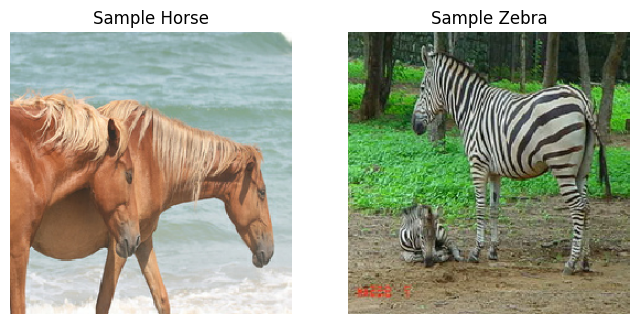

In [24]:
# @title Data Loading and Preprocessing

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

# Normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # Resizing to 286x286
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # Randomly cropping to 256x256
  image = random_crop(image)
  # Random mirroring
  image = tf.image.random_flip_left_right(image)
  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  # Only normalize for testing
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # Resize directly
  image = normalize(image)
  return image

# Load the dataset
try:
    dataset, metadata = tfds.load(DATASET_NAME,
                                  with_info=True,
                                  as_supervised=True)

    train_horses, train_zebras = dataset['trainA'], dataset['trainB']
    test_horses, test_zebras = dataset['testA'], dataset['testB']

    # Apply preprocessing
    train_horses = train_horses.map(
        preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    train_zebras = train_zebras.map(
        preprocess_image_train, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    test_horses = test_horses.map(
        preprocess_image_test, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    test_zebras = test_zebras.map(
        preprocess_image_test, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    print("Dataset loaded and preprocessed successfully.")
    # Get a sample image from each domain for visualization
    sample_horse = next(iter(train_horses))
    sample_zebra = next(iter(train_zebras))
    print(f"Sample horse shape: {sample_horse.shape}, dtype: {sample_horse.dtype}")
    print(f"Sample zebra shape: {sample_zebra.shape}, dtype: {sample_zebra.dtype}")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure you have internet connectivity and the dataset name is correct.")

# Visualize a sample
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Sample Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5) # Denormalize
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Sample Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5) # Denormalize
plt.axis('off')
plt.show()

I0000 00:00:1745789435.509153      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


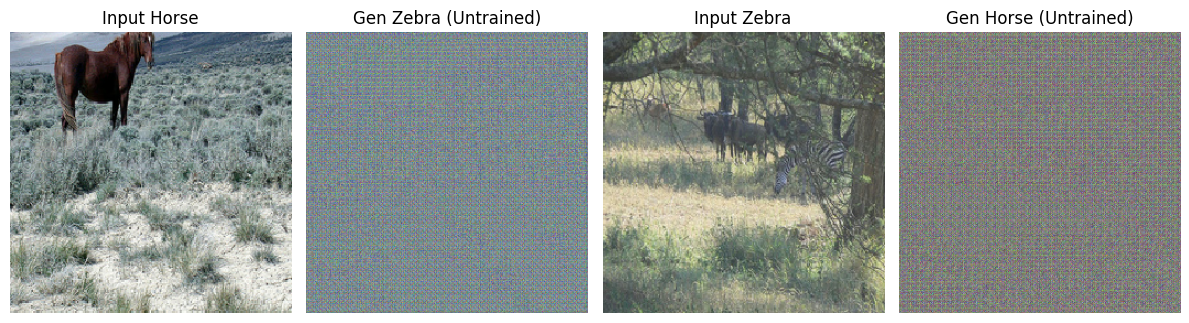

In [25]:
# Cell 4: Generator Model (ResNet-based) - Using LayerNormalization


# LayerNormalization normalizes across the feature axis.
# For image data (Batch, Height, Width, Channels), axis=[1, 2, 3] normalizes across all spatial and channel dims.
# Axis=[3] normalizes only across the channel dimension (more common usage).axis=-1 (channels) initially.
# experiment with axis=[1, 2] or axis=[1, 2, 3] if results are poor.
NormalizationLayer = lambda: tf.keras.layers.LayerNormalization(axis=-1) # Normalize across channel dimension
# --------------------------------------------------------------

def downsample(filters, size, apply_norm=True):
  """Downsamples an input. Conv2D => Norm => LeakyReLU"""
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  if apply_norm:
    result.add(NormalizationLayer()) # Use LayerNorm
  result.add(tf.keras.layers.LeakyReLU())
  return result

def upsample(filters, size, apply_dropout=False):
  """Upsamples an input. Transposed Conv2D => Norm => Dropout => ReLU"""
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
  result.add(NormalizationLayer()) # Use LayerNorm
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.ReLU())
  return result

# build_generator function remains structurally the same, but now uses
# the modified downsample/upsample functions above which contain LayerNorm
def build_generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS])
  down_stack = [
      downsample(64, 4, apply_norm=False), (downsample(128, 4)), (downsample(256, 4)),
      (downsample(512, 4)), (downsample(512, 4)), (downsample(512, 4)),
      (downsample(512, 4)), (downsample(512, 4)),
  ]
  up_stack = [
      upsample(512, 4, apply_dropout=True), (upsample(512, 4, apply_dropout=True)),
      (upsample(512, 4, apply_dropout=True)), (upsample(512, 4)), (upsample(256, 4)),
      (upsample(128, 4)), (upsample(64, 4)),
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      OUTPUT_CHANNELS, 4, strides=2, padding='same',
      kernel_initializer=initializer, activation='tanh')
  x = inputs
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

# Build the two generators
generator_g = build_generator() # Translates A -> B (e.g., Horse -> Zebra)
generator_f = build_generator() # Translates B -> A (e.g., Zebra -> Horse)

# Visualize a generated sample (untrained) - code remains the same
# (Error handling for sample images also remains)
try:
    sample_horse = next(iter(train_horses)) # Use sample_horse from Cell 3
    sample_zebra = next(iter(train_zebras)) # Use sample_zebra from Cell 3
    to_zebra = generator_g(sample_horse)
    to_horse = generator_f(sample_zebra)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1); plt.title("Input Horse"); plt.imshow(sample_horse[0] * 0.5 + 0.5); plt.axis('off')
    plt.subplot(1, 4, 2); plt.title("Gen Zebra (Untrained)"); plt.imshow(to_zebra[0] * 0.5 + 0.5); plt.axis('off')
    plt.subplot(1, 4, 3); plt.title("Input Zebra"); plt.imshow(sample_zebra[0] * 0.5 + 0.5); plt.axis('off')
    plt.subplot(1, 4, 4); plt.title("Gen Horse (Untrained)"); plt.imshow(to_horse[0] * 0.5 + 0.5); plt.axis('off')
    plt.tight_layout()
    plt.show()
except NameError:
    print("Skipping untrained visualization as sample images were not loaded.")
except Exception as e:
     print(f"Error during untrained visualization: {e}")

In [26]:
# Cell 5: Discriminator Model (PatchGAN) - Using LayerNormalization


# NormalizationLayer = lambda: tf.keras.layers.LayerNormalization(axis=-1) # Defined in Cell 4
# ----------------------------------------------------

# build_discriminator uses the modified downsample function from Cell 4
def build_discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, OUTPUT_CHANNELS], name='input_image')

  # Downsampling uses the modified downsample function with LayerNorm
  down1 = downsample(64, 4, False)(inp)
  down2 = downsample(128, 4)(down1)
  down3 = downsample(256, 4)(down2)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

  # --- Apply LayerNorm after the intermediate convolution ---
  norm1 = NormalizationLayer()(conv) # Use LayerNorm here too
  # ----------------------------------------------------------

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
  last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
  return tf.keras.Model(inputs=inp, outputs=last)

# Build the two discriminators
discriminator_x = build_discriminator() # Discriminator for domain A (Horses)
discriminator_y = build_discriminator() # Discriminator for domain B (Zebras)

# Visualize discriminator output shape (untrained) - code remains the same
# (Error handling for sample images also remains)
try:
    disc_out_x = discriminator_x(sample_horse)
    disc_out_y = discriminator_y(sample_zebra)
    print(f"Discriminator X output shape: {disc_out_x.shape}")
    print(f"Discriminator Y output shape: {disc_out_y.shape}")
except NameError:
    print("Skipping discriminator output visualization as sample images were not loaded.")
except Exception as e:
     print(f"Error during discriminator output visualization: {e}")

Discriminator X output shape: (1, 30, 30, 1)
Discriminator Y output shape: (1, 30, 30, 1)


In [28]:
# @title Loss Functions

# Use Mean Squared Error for LSGAN (Least Squares GAN) - tends to be more stable
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, generated):
  """LSGAN loss for discriminator"""
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5 # Scale down by 0.5

def generator_loss(generated):
  """LSGAN loss for generator"""
  # Generator wants discriminator to think the generated image is real
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  """Cycle consistency loss (L1 loss)"""
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA_CYCLE * loss1

def identity_loss(real_image, same_image):
  """Identity loss (L1 loss)"""
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA_ID * loss


In [30]:
# @title Optimizers
# Define optimizers for generators and discriminators 
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)



In [31]:
# @title Checkpoints
checkpoint = tf.train.Checkpoint(generator_g=generator_g,
                                 generator_f=generator_f,
                                 discriminator_x=discriminator_x,
                                 discriminator_y=discriminator_y,
                                 generator_g_optimizer=generator_g_optimizer,
                                 generator_f_optimizer=generator_f_optimizer,
                                 discriminator_x_optimizer=discriminator_x_optimizer,
                                 discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  checkpoint.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')


In [32]:
# @title Training Step Definition

# Use tf.function for optimized graph execution
@tf.function
def train_step(real_x, real_y):
  # real_x: image from domain A (e.g., horse)
  # real_y: image from domain B (e.g., zebra)

  # persistent=True is necessary because we need to compute gradients
  # for four different models (two generators, two discriminators) using the same tape.
  with tf.GradientTape(persistent=True) as tape:
    # --- Generator Computations ---
    # Generate fake images
    fake_y = generator_g(real_x, training=True) # A -> B (fake Zebra)
    cycled_x = generator_f(fake_y, training=True) # B -> A (cycled Horse)

    fake_x = generator_f(real_y, training=True) # B -> A (fake Horse)
    cycled_y = generator_g(fake_x, training=True) # A -> B (cycled Zebra)

    # Identity mapping (feed image from target domain to generator)
    same_x = generator_f(real_x, training=True) # Should be close to real_x
    same_y = generator_g(real_y, training=True) # Should be close to real_y

    # --- Discriminator Computations ---
    # Discriminator predictions for real images
    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    # Discriminator predictions for fake images
    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # --- Loss Calculations ---
    # Generator Adversarial Loss (LSGAN)
    gen_g_loss = generator_loss(disc_fake_y) # G wants DiscY to output 1 for fake_y
    gen_f_loss = generator_loss(disc_fake_x) # F wants DiscX to output 1 for fake_x

    # Cycle Consistency Loss (L1)
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total Generator Loss = Adversarial Loss + Cycle Loss + Identity Loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    # Discriminator Loss (LSGAN)
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # --- Calculate Gradients ---
  # Generator gradients
  generator_g_gradients = tape.gradient(total_gen_g_loss,
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss,
                                        generator_f.trainable_variables)

  # Discriminator gradients
  discriminator_x_gradients = tape.gradient(disc_x_loss,
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss,
                                            discriminator_y.trainable_variables)

  # --- Apply Gradients ---
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))
  generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                              discriminator_x.trainable_variables))
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                              discriminator_y.trainable_variables))

  # Delete the tape after use (required when persistent=True)
  del tape

  return {
      "gen_g_loss": total_gen_g_loss,
      "gen_f_loss": total_gen_f_loss,
      "disc_x_loss": disc_x_loss,
      "disc_y_loss": disc_y_loss,
      "cycle_loss": total_cycle_loss,
      "id_loss_g": identity_loss(real_y, same_y),
      "id_loss_f": identity_loss(real_x, same_x)
  }

In [35]:
# @title Image Generation and Display Function

def generate_images(model_g, model_f, test_input_x, test_input_y, epoch=-1):
  # Generate translations: X -> Y and Y -> X
  prediction_y = model_g(test_input_x, training=False) # Horse -> Zebra
  prediction_x = model_f(test_input_y, training=False) # Zebra -> Horse

  # For cycle visualization (optional but good):
  cycled_x = model_f(prediction_y, training=False) # Horse -> Zebra -> Horse
  cycled_y = model_g(prediction_x, training=False) # Zebra -> Horse -> Zebra

  plt.figure(figsize=(12, 8)) # Adjusted size for clarity

  display_list_x = [test_input_x[0], prediction_y[0], cycled_x[0]]
  display_list_y = [test_input_y[0], prediction_x[0], cycled_y[0]]
  title_x = ['Input Image (X)', 'Predicted Image (Y)', 'Cycled Image (X)']
  title_y = ['Input Image (Y)', 'Predicted Image (X)', 'Cycled Image (Y)']

  # Plot X -> Y -> X cycle
  for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.title(title_x[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list_x[i] * 0.5 + 0.5)
    plt.axis('off')

  # Plot Y -> X -> Y cycle
  for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.title(title_y[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list_y[i] * 0.5 + 0.5)
    plt.axis('off')

  if epoch >= 0:
      plt.suptitle(f"Epoch {epoch+1}", fontsize=16)

  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
  plt.show()

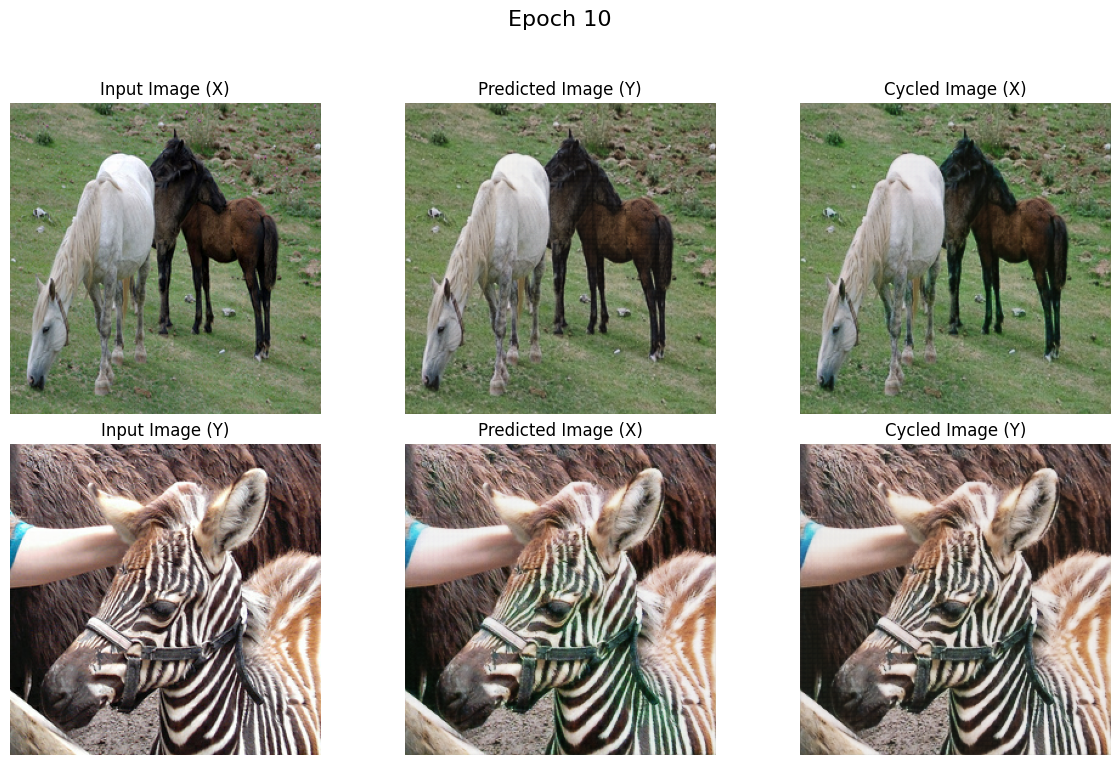

Epoch 10 finished in 499.64 sec
  Avg GenG Loss: 1.4342, Avg GenF Loss: 1.4128
  Avg DiscX Loss: 0.2121, Avg DiscY Loss: 0.2010
Saving checkpoint for epoch 10 at ./training_checkpoints/ckpt-2

Total Training Time: 83 min 59 sec


In [36]:
# @title Training Loop

# Get fixed test samples for consistent visualization during training
vis_horse = next(iter(test_horses))
vis_zebra = next(iter(test_zebras))

print("Starting training...")
start_time = time.time()

for epoch in range(EPOCHS):
  epoch_start_time = time.time()
  n = 0
  epoch_losses = {"gen_g_loss": 0.0, "gen_f_loss": 0.0, "disc_x_loss": 0.0, "disc_y_loss": 0.0}

  # Iterate over the dataset, zipping train_horses and train_zebras
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    losses = train_step(image_x, image_y)

    # Accumulate losses for reporting
    for k, v in losses.items():
        if k in epoch_losses:
            epoch_losses[k] += v
    n += 1

    if n % 100 == 0: # Print progress every 100 steps
      print (f'Epoch {epoch+1}, Step {n}, '
             f'GenG Loss: {losses["gen_g_loss"]:.4f}, GenF Loss: {losses["gen_f_loss"]:.4f}, '
             f'DiscX Loss: {losses["disc_x_loss"]:.4f}, DiscY Loss: {losses["disc_y_loss"]:.4f}, '
             f'Cycle Loss: {losses["cycle_loss"]:.4f}, '
             f'Time: {time.time()-epoch_start_time:.2f} sec')

  clear_output(wait=True)

  # Generate and display images at the end of each epoch
  generate_images(generator_g, generator_f, vis_horse, vis_zebra, epoch)

  # Print epoch summary
  print (f'Epoch {epoch+1} finished in {time.time()-epoch_start_time:.2f} sec')
  print (f'  Avg GenG Loss: {epoch_losses["gen_g_loss"]/n:.4f}, Avg GenF Loss: {epoch_losses["gen_f_loss"]/n:.4f}')
  print (f'  Avg DiscX Loss: {epoch_losses["disc_x_loss"]/n:.4f}, Avg DiscY Loss: {epoch_losses["disc_y_loss"]/n:.4f}')


  # Save the model every 5 epochs (adjust as needed)
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')


total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time // 60:.0f} min {total_time % 60:.0f} sec")

In [ ]:
# @title Final Results Visualization
print("\nShowing final results on a few test samples...")

# Show results on a few test images
num_test_samples = 3
test_iter_horses = iter(test_horses)
test_iter_zebras = iter(test_zebras)

for i in range(num_test_samples):
    try:
        horse_sample = next(test_iter_horses)
        zebra_sample = next(test_iter_zebras)
        print(f"\nTest Sample {i+1}:")
        generate_images(generator_g, generator_f, horse_sample, zebra_sample)
    except StopIteration:
        print("Reached end of test dataset.")
        break
    except Exception as e:
        print(f"Error generating results for sample {i+1}: {e}")